In [1]:
import os
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import cv2

In [2]:
from tensorflow.keras.optimizers import Adam
import h5py
from sklearn.metrics.pairwise import cosine_similarity
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
image_size = (128, 128)
batch_size = 10
epochs = 150

In [4]:
def preprocessing_image(image_path):
    image = imread(image_path)
    image_resized = resize(image, image_size, anti_aliasing=True)
    return image_resized

def load_image(folder_path):
    images = []
    names = []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = preprocessing_image(img_path)
        images.append(img)
        names.append(img_name)
    return np.array(images), np.array(names)

In [5]:
path = "/Users/sudipkhadka/Desktop/mlop/semantic_search/images/"

In [6]:
X, names = load_image(path)
X = X.astype('float32') /255.0 #normalize the pixel values between 0 and 1

In [7]:
def simple_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    return model

In [8]:
#Initialize
input_shape = (image_size[0], image_size[1], 3) #height, width, channels
model = simple_cnn_model(input_shape)

/Users/sudipkhadka/Desktop/mlop/semantic_search/.ml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
#compile
model.compile(optimizer=Adam(), loss='mean_squared_error')

In [10]:
dummy_targets = np.random.rand(X.shape[0], 128)

In [11]:
model.fit(X, dummy_targets, batch_size=batch_size, epochs=epochs)

Epoch 1/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.2558
Epoch 2/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.1430
Epoch 3/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.1149
Epoch 4/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.1021
Epoch 5/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.1003
Epoch 6/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0955
Epoch 7/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0979
Epoch 8/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0947
Epoch 9/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0921
Epoch 10/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0923
Epoch 11/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0915
Epoch 12/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0917
Epoch 13/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0907
Epoch 14/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0915
Epoch 15/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - lo

In [12]:
cnn_features = model.predict(X)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [73]:
cnn_feature_file = "ImageFeatures.h5"
print("Saving features to h5 file")
cnn_h5f = h5py.File(cnn_feature_file, "w")
cnn_h5f.create_dataset("features", data=cnn_features)
cnn_h5f.create_dataset("name", data=np.array(names, dtype='S'))  
cnn_h5f.close()

Saving features to h5 file


In [56]:
def reterive_similar_images(query_image_path, cnn_features, names, top_k=5):
    query_image = preprocessing_image(query_image_path)
    query_image = query_image.astype('float32') / 255.0
    query_feature = model.predict(np.expand_dims(query_image, axis=0))
    similarities = cosine_similarity(query_feature, cnn_features)[0]
    similar_indecis = np.argsort(similarities)[-top_k:][::-1]
    similar_images = names[similar_indecis]
    return similar_images, similar_indecis

In [57]:
image_directory = '/Users/sudipkhadka/Desktop/mlop/semantic_search/images'

In [70]:
query_image_path = "/Users/sudipkhadka/Desktop/mlop/semantic_search/images/102a41e311.jpg"
similar_images, similarity_scores = reterive_similar_images(query_image_path, cnn_features, names)

print("similar Images:")
for img, score in zip(similar_images, similarity_scores):
    print(f"Images: {img}, Similarity Score: {score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
similar Images:
Images: 0f6ba7d62b.jpg, Similarity Score: 180.0000
Images: 2f714376e6.jpg, Similarity Score: 66.0000
Images: 3d31511901.jpg, Similarity Score: 64.0000
Images: 00dc9380ee.jpg, Similarity Score: 63.0000
Images: 0a47b7d021.jpg, Similarity Score: 62.0000


Text(0.5, 1.0, 'Query Image')

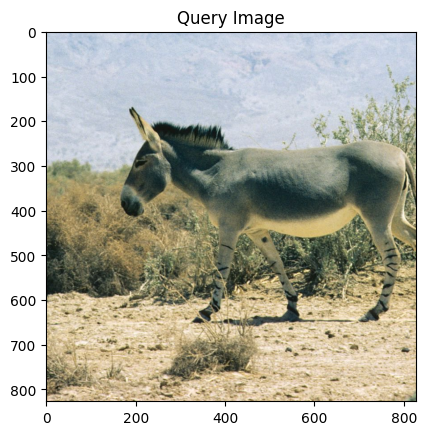

In [65]:
plt.imshow(io.imread(query_image_path))
plt.title('Query Image')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


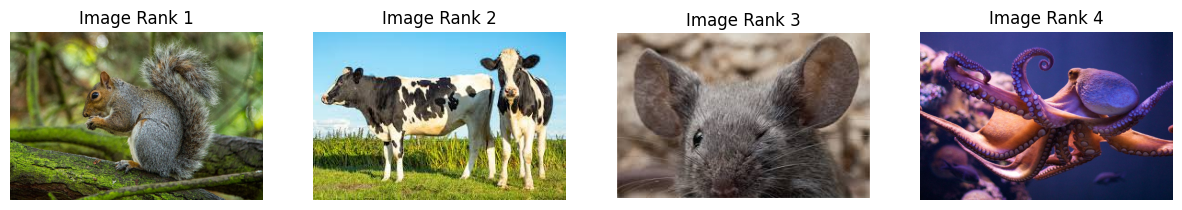

In [79]:
top_k = 4
similar_images, similar_indices = reterive_similar_images(query_image_path, cnn_features, names, top_k)
lists = [os.path.join(image_directory, names[index].decode('utf-8')) if isinstance(names[index], bytes) 
         else os.path.join(image_directory, names[index]) 
         for index in similar_indices[0:top_k]] 

num_images = len(lists)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i, image_path in enumerate(lists):
    if os.path.exists(image_path):
        img = mpimg.imread(image_path)  
        axes[i].imshow(img)             
        axes[i].axis('off')             
        axes[i].set_title(f"Image Rank {i+1}") 
    else:
        print(f"File not found: {image_path}")  

plt.show()